In [1]:
import numpy as np
import pandas as pd
import plotly.express as px

import matplotlib.pyplot as plt


from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

from xgboost import XGBRegressor

In [2]:
def prepare_data():
    broadband = read_broadband()
    county_population_density_per_square_mile = read_county_population_density_per_square_mile()
    postal_code_population = read_postal_code_population()

    data = (broadband
    .merge(county_population_density_per_square_mile, on='county_id')
    .merge(postal_code_population, on='postal_code'))

    data['population_without_broadband'] = np.ceil((1. - data.broadband_usage) * data.population)

    return data[[
        'st', 
        'county_id', 'county_name', 'density_per_square_mile', 
        'postal_code', 'population', 'population_without_broadband',
        'broadband_usage', 'error_range_mae', 'error_range_95', 'msd'
    ]], postal_code_population

def read_broadband():
    broadband = pd.read_csv('datasets/broadband_data.csv', sep=';')
    broadband.rename(columns={
        'error_range_(mae)(+/-)': 'error_range_mae',
        'error_range_(95%)(+/-)': 'error_range_95'
    }, inplace=True)

    for column in ['broadband_usage', 'error_range_mae', 'error_range_95',	'msd']:
        broadband[column] = broadband[column].str.replace(',', '.').astype('float64')
    # Converte county_id em string e prefixa '0' nos ids com 4 caracteres
    broadband.county_id = broadband.county_id.apply('{:0>5}'.format)
    # Remove county_ids de condatos equivalentes (Alguns CEPs estavam duplicados)
    broadband.drop(broadband[broadband.county_id.isin(['02158', '46102', '27111', '27163'])].index, inplace=True)
    
    return broadband


def read_county_population_density_per_square_mile():
    population_density = pd.read_csv('datasets/density-per-square-mile.csv', sep=',')
    population_density.rename(columns={
        'GCT_STUB.target-geo-id2': 'county_id',
        'Density per square mile of land area': 'density_per_square_mile'
    }, inplace=True)

    population_density.county_id = population_density.county_id.apply('{:0>5}'.format)

    return population_density[['county_id', 'density_per_square_mile']]


def read_postal_code_population():
    return pd.read_csv('datasets/population_by_zipcode_2010.csv')

In [3]:
data, _ = prepare_data()

In [4]:
x = data[['st', 'density_per_square_mile', 'population']]
y = data.population_without_broadband

x_data, x_test, y_data, y_test = train_test_split(x, y, test_size=0.25)
x_train, x_valid, y_train, y_valid = train_test_split(x_data, y_data, test_size=0.25)

In [5]:
def prepare_input_data(encoder, x):
    x_encoded = pd.DataFrame(encoder.transform(x[['st']]))
    x_encoded.columns = encoder.get_feature_names(['st'])
    x_encoded = pd.concat([x.drop(columns=['st']).reset_index(drop=True), x_encoded.reset_index(drop=True)], axis=1)
    return x_encoded

In [6]:
oneHotEncoder = preprocessing.OneHotEncoder(sparse=False, handle_unknown='ignore').fit(x_train[['st']])

x_train = prepare_input_data(oneHotEncoder, x_train)
x_valid = prepare_input_data(oneHotEncoder, x_valid)
x_test = prepare_input_data(oneHotEncoder, x_test)

In [7]:
model = XGBRegressor(n_estimators=100, max_depth=2, learning_rate=0.1, reg_alpha=.05, reg_lambda=.05)
model.fit(x_train, y_train, 
            eval_set=[(x_train, y_train), (x_valid, y_valid)], 
            early_stopping_rounds=20,
            verbose=False)

results = model.evals_result()

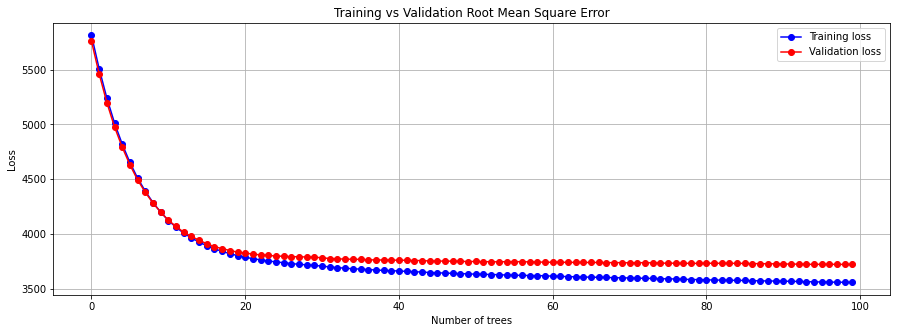

In [8]:
plt.figure(figsize=(15,5))
plt.title('Training vs Validation Root Mean Square Error')
plt.plot(results["validation_0"]["rmse"], "bo-", label="Training loss")
plt.plot(results["validation_1"]["rmse"], "ro-", label="Validation loss")
plt.xlabel("Number of trees")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()

In [9]:
mean_absolute_error(y_test, model.predict(x_test)).round(2)

1845.1